In [1]:
# run CW ODMR.
# control the frequency changes "manually" with the code here instead of using external trigger

In [1]:
%matplotlib inline

In [2]:
import nidaqmx
import numpy as np
import qt3rfsynthcontrol
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt
import qcsapphire
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
nisys = nidaqmx.system.System()
device = nidaqmx.system.Device('Dev1')

In [4]:
list(nisys.tasks)

[]

In [5]:
device.reset_device()

In [6]:
#list(nisys.devices)

In [7]:
#device = nidaqmx.system.Device('Dev1')
#list(device.ao_physical_chans)
# list(device.ai_physical_chans)
#list(device.di_lines)
#list(device.do_lines)
#list(device.co_physical_chans)
#list(device.ci_physical_chans)
# list(device.terminals)

In [8]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    clock_di_line = 'port0',
                    edge_input_channel = 'PFI12',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500,
                    trigger_input = None,
                    new_edge_task = False,
                    new_clock_task = False,
                    continuous_daq = False):
   
    #clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task()
       
    if new_clock_task:
        clock_task.di_channels.add_di_chan(f'{device_name}/{clock_di_line}')
        clock_task.timing.cfg_samp_clk_timing(clock_rate,
                                    sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)
     
        clock_channel = f'/{device_name}/di/SampleClock'

    else:
        #this adds the clock signal to the output channel
        #is this necessary? 
        clock_task.co_channels.add_co_pulse_chan_freq(
                '/{0}/{1}'.format(device_name, clock_counter),
                freq=clock_rate,
                idle_state=nidaqmx.constants.Level.LOW)

        # clock_task.timing.cfg_implicit_timing(
        #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_task.timing.cfg_implicit_timing(
            sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
            samps_per_chan=clock_rate) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

        clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    #edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task()

    #todo -- try to replace all of this with edge_detector_task.add_ci_count_edges_chan
    
    

    ctr_name = f'/{device_name}/{edge_input_counter}'
    chnl_name = f'/{device_name}/{edge_input_channel}'
    
    if new_edge_task: #following nspyre recipe -- this does not seem to work! 
        #I get counts out, but they are very weakly correlated to PL intensity compared to the qudi setup 
        #
        channel = edge_detector_task.ci_channels.add_ci_count_edges_chan(
                                    ctr_name,
                                    edge=nidaqmx.constants.Edge.RISING,
                                    initial_count=0,
                                    count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        channel.ci_count_edges_term = chnl_name 
        
        if continuous_daq:
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS)    
        else:        
            edge_detector_task.timing.cfg_samp_clk_timing(clock_rate, 
                                                          source=clock_channel,
                                                          active_edge=nidaqmx.constants.Edge.RISING, 
                                                          sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                          samps_per_chan=N_data_samples_to_acquire)
        
    else:
        # why does qudi count the period of signal? In units of "ticks" -- is that the same as edge counting? 
        
        edge_detector_task.ci_channels.add_ci_period_chan(
                            ctr_name,
                            min_val=0,
                            max_val=100000000,
                            units=nidaqmx.constants.TimeUnits.TICKS,
                            edge=nidaqmx.constants.Edge.RISING)
        # I get no data when I swap out the line above for this line
        # edge_detector_task.ci_channels.add_ci_count_edges_chan(
        #                             ctr_name,
        #                             edge=nidaqmx.constants.Edge.RISING,
        #                             initial_count=0,
        #                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
        
        # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
        try:
            # this sets the counter to read from the appropriate terminal
            nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            
            #this tells the counter which clock to use
            nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))
        except:
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(clock_channel.encode('ascii')))
            nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
                edge_detector_task._handle,
                ctypes.c_char_p(ctr_name.encode('ascii')),
                ctypes.c_char_p(chnl_name.encode('ascii')))

        edge_detector_task.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
                                                      samps_per_chan=N_data_samples_to_acquire)
    
    if trigger_input:
        trigger_channel = f'/{device_name}/{trigger_input}'
        print(f'setting up trigger input on {trigger_channel}')
        #for counters, we use 'arm-start-trigger' instead of 'start-trigger'. 
        #the ni documentation is confusing. just eat the fish. 
        edge_detector_task.triggers.arm_start_trigger.trig_type =  nidaqmx.constants.TriggerType.DIGITAL_EDGE
        edge_detector_task.triggers.arm_start_trigger.dig_edge_edge =  nidaqmx.constants.Edge.RISING
        edge_detector_task.triggers.arm_start_trigger.dig_edge_src = trigger_channel
        
        #this does not work. its designed for analog/digital input/output tasks, not counter tasks
        #edge_detector_task.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_channel)
    

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [9]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10, pulser = None):
    
    detector_task.wait_until_done() #this doesn't seem to always work
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    
    if pulser:
        pulser.software_trigger()
    
    time.sleep(N_samples / clock_rate * 1.1)
    
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [10]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [11]:
rfsynth.hw_info()

[('model_type', 'WFT SynthHD 1694'),
 ('serial_number', 1694),
 ('fw_version', 'Firmware Version 3.23'),
 ('hw_version', 'Hardware Version 2.06'),
 ('sub_version', 'HD')]

In [12]:
qcsapphire.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-10:x.0'],
 ['COM10',
  'USB Serial Device (COM10)',
  'USB VID:PID=04D8:000A SER= LOCATION=1-2:x.0']]

In [13]:
p = qcsapphire.Pulser('COM10')

In [14]:
p.set_all_state_off()

In [52]:
p.close()
p.open()

In [53]:
# set up pulser to hold open laser and MW
aom_pulser_channel = 'A'
mw_source_pulser_channel = 'B'

In [93]:
p.system.mode('normal')
p.system.period(.001)
p.system.external.mode('disabled')

'ok'

In [94]:
p.channel(aom_pulser_channel).cmode('normal')
p.channel(aom_pulser_channel).polarity('normal')
p.channel(aom_pulser_channel).width(0.9999*float(p.system.period()))
p.channel(aom_pulser_channel).delay(0) 
p.channel(aom_pulser_channel).mux(2**(p._conver_channel_name_to_int(aom_pulser_channel)-1))

p.channel(aom_pulser_channel).state(1)

'ok'

In [95]:
#just output channel same as aom channel
p.channel(mw_source_pulser_channel).mux(2**(p._conver_channel_name_to_int(aom_pulser_channel)-1))

p.channel(mw_source_pulser_channel).state(1)

'ok'

In [85]:
p.system.state(1)

'ok'

In [15]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(p.report_global_settings())

for chan in p.channel_names()[1:]:
    pp.pprint(f'channel {chan}')
    pp.pprint(p.report_channel_settings(chan))

[   (':PULSE0:STATE?', '0'),
    (':PULSE0:PERIOD?', '0.001000000'),
    (':PULSE0:MODE?', 'NORM'),
    (':PULSE0:BCOUNTER?', '5'),
    (':PULSE0:PCOUNTER?', '3'),
    (':PULSE0:OCOUNTER?', '2'),
    (':PULSE0:EXTERNAL:MODE?', 'DIS'),
    (':PULSE0:EXTERNAL:LEVEL?', '2.50'),
    (':PULSE0:EXTERNAL:EDGE?', 'RIS'),
    (':PULSE0:EXTERNAL:POLARITY?', 'HIGH')]
'channel A'
[   (':PULSE1:STATE?', '0'),
    (':PULSE1:WIDTH?', '0.000999900'),
    (':PULSE1:DELAY?', '0.00000000'),
    (':PULSE1:SYNC?', 'T0'),
    (':PULSE1:MUX?', '1'),
    (':PULSE1:POLARITY?', 'NORM'),
    (':PULSE1:OUTPUT:AMPLITUDE?', '5.00'),
    (':PULSE1:CMODE?', 'NORM'),
    (':PULSE1:BCOUNTER?', '5'),
    (':PULSE1:PCOUNTER?', '4'),
    (':PULSE1:WCOUNTER?', '0'),
    (':PULSE1:CGATE?', 'DIS')]
'channel B'
[   (':PULSE2:STATE?', '0'),
    (':PULSE2:WIDTH?', '0.999990000'),
    (':PULSE2:DELAY?', '0.00000000'),
    (':PULSE2:SYNC?', 'T0'),
    (':PULSE2:MUX?', '1'),
    (':PULSE2:POLARITY?', 'NORM'),
    (':PULSE2:OUTPUT:

In [17]:
def run_with_options(freq_low, freq_high, freq_step,
                     N_samples_per_step, clock_rate, 
                     trigger_input, pulser, rfsynth, 
                     use_new_edge_task, new_clock_task, 
                     continuous_daq, normalize, rf_power,
                     cooling_time = 0):


    data = None


    try:
        daq_time = N_samples_per_step / clock_rate
        print(f'acquiring {daq_time} seconds of data per sample')

        clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v4', 
                                                                                clock_rate = clock_rate, 
                                                                                N_data_samples_to_acquire = N_samples_per_step,
                                                                                edge_input_channel = 'PFI12',
                                                                                clock_counter = 'ctr1',
                                                                                trigger_input = trigger_input,
                                                                                new_edge_task = use_new_edge_task,
                                                                                new_clock_task = new_clock_task,
                                                                                continuous_daq = continuous_daq)

        if clock_task:
            clock_task.start()

        data = {}
        
        current_freq = freq_low
        step = 0

        # if pulser:
        #     pulser.system.state(1)
        #     pulser.channel(daq_pulser_trigger_channel).state(1)

        
            
        while current_freq < freq_high:
            if rfsynth:
                rfsynth.set_channel_fixed_output(0, rf_power, current_freq)
                time.sleep(0.001)
                
            if normalize:
                if rfsynth:
                    rfsynth.rf_off(0)
                    time.sleep(0.03)

                normalized_count_rate_pre = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
          
                if rfsynth:
                    rfsynth.rf_on(0)
                    time.sleep(0.03)
                
            data_at_one_freq = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
            
            if normalize:
                if rfsynth:
                    rfsynth.rf_off(0)
                    time.sleep(0.03)
                normalized_count_rate_post = run_once(edge_detector_task, edge_detector_reader, clock_rate, N_samples_per_step, read_write_timeout = 10, pulser = pulser)
                normalized_count_rate = np.mean([normalized_count_rate_pre,normalized_count_rate_post])
                data[current_freq] = data_at_one_freq.mean() / normalized_count_rate
            else:
                data[current_freq] = data_at_one_freq.mean() * clock_rate
                
            if step % 10 == 0:
                if normalize:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} normalized intensity')
                else:
                    print(f'{current_freq/1e9} GHz: {data[current_freq]} mean counts/second')
            current_freq += freq_step
            step += 1
            
            time.sleep(cooling_time)
            
    except Exception as e:
        print(e)
        raise(e)

    finally:

        try:
            if rfsynth:
                rfsynth.rf_off(0)
            # if pulser:
            #     pulser.system.state(0)
            #     pulser.channel(daq_pulser_trigger_channel).state(0)
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.stop()
        except Exception as e:
            print(e)

        try:
            if clock_task:
                clock_task.close()
        except Exception as e:
            print(e)

        try:
            if edge_detector_task:
                edge_detector_task.close()
        except Exception as e:
            print(e)
            
        return data

In [35]:
rfsynth.set_channel_fixed_output(0, -5, 2800e6)
rfsynth.rf_on(0)

acquiring 0.25 seconds of data per sample
2.85 GHz: 0.9832245955042997 normalized intensity
2.86 GHz: 0.9488346932335572 normalized intensity
2.87 GHz: 0.9009067241224525 normalized intensity
2.88 GHz: 0.9317367205957653 normalized intensity
2.89 GHz: 0.9724927387664446 normalized intensity


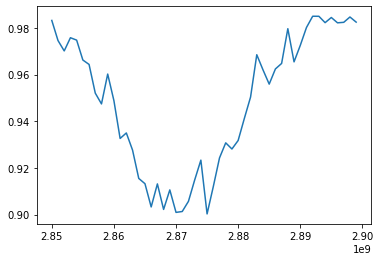

In [37]:
#now hardware is set up in podmr with AOM held open -- green laser power is significantly smaller than before

freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = False
new_clock_task = True
continuous_daq = False
normalize = True
rf_power = -5


data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
    
    
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
2.85 GHz: 1.0023966770558677 normalized intensity
2.86 GHz: 0.9961617107613976 normalized intensity
2.87 GHz: 0.9856647684718702 normalized intensity
2.88 GHz: 0.9931565587430352 normalized intensity
2.89 GHz: 0.9933000570613953 normalized intensity


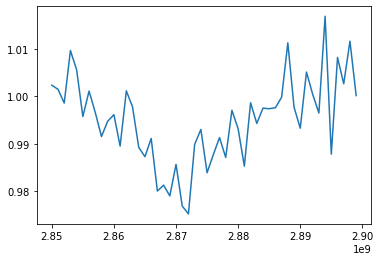

In [39]:
#now hardware is set up in podmr with AOM held open -- green laser power is significantly smaller than before

#using the pulser
freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = None
pulser = None
rf = rfsynth
use_new_edge_task = True
new_clock_task = True
continuous_daq = False
normalize = True
rf_power = -20

# pulser.system.state(1)
# pulser.channel(daq_pulser_trigger_channel).state(1)
    
data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)

# pulser.system.state(0)
# pulser.channel(daq_pulser_trigger_channel).state(0)
    
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
setting up trigger input on /Dev1/PFI0
2.85 GHz: 1.0049004246842919 normalized intensity
2.86 GHz: 1.0041783098289374 normalized intensity
2.87 GHz: 0.9826495714351425 normalized intensity
2.88 GHz: 0.9936019444196783 normalized intensity
2.89 GHz: 1.0069112840936376 normalized intensity


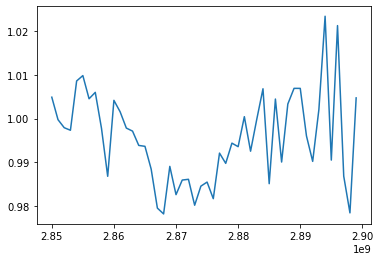

In [37]:
#now hardware is set up in podmr with AOM held open -- green laser power is significantly smaller than before

#using the pulser
freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = 'PFI0'
pulser = p
rf = rfsynth
use_new_edge_task = True
new_clock_task = True
continuous_daq = False
normalize = True
rf_power = -20

pulser.system.state(1)
pulser.channel(daq_pulser_trigger_channel).state(1)
    
data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)

pulser.system.state(0)
pulser.channel(daq_pulser_trigger_channel).state(0)
    
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
setting up trigger input on /Dev1/PFI0
fake trigger
Some or all of the samples requested have not yet been acquired.
To wait for the samples to become available use a longer read timeout or read later in your program. To make the samples available sooner, increase the sample rate. If your task uses a start trigger,  make sure that your start trigger is configured correctly. It is also possible that you configured the task for external timing, and no clock was supplied. If this is the case, supply an external clock.
Property: DAQmx_Read_RelativeTo
Requested Value: DAQmx_Val_CurrReadPos

Property: DAQmx_Read_Offset
Requested Value: 0

Task Name: edge_inputv162

Status Code: -200284


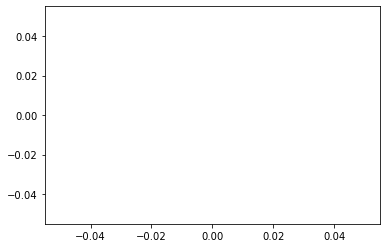

In [60]:
#now hardware is set up in podmr with AOM held open -- green laser power is significantly smaller than before

#using the pulser

class FakePulser:
    def software_trigger(self):
        print('fake trigger')
    
freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = 'PFI0'
pulser = FakePulser()
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)
plt.plot(data_qudi_style.keys(), data_qudi_style.values())

acquiring 0.25 seconds of data per sample
setting up trigger input on /Dev1/PFI0
2.85 GHz: 0.9980433043041465 normalized intensity
2.86 GHz: 1.0031262647295165 normalized intensity
2.87 GHz: 0.9649572450429879 normalized intensity
2.88 GHz: 0.9918390697239994 normalized intensity
2.89 GHz: 1.0007942069609903 normalized intensity


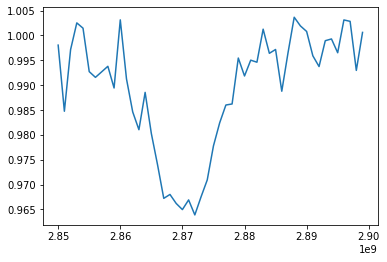

In [40]:
#now hardware is set up in podmr with AOM held open -- green laser power is significantly smaller than before

#using the pulser
freq_low = 2850e6
freq_high = 2900e6
freq_step = 1e6
N = 50
clock_rate = 200 #Hz
trigger_input = 'PFI0'
pulser = p
rf = rfsynth
use_new_edge_task = False
new_clock_task = False
continuous_daq = False
normalize = True
rf_power = -20

pulser.system.state(1)
pulser.channel(daq_pulser_trigger_channel).state(1)
    
data_qudi_style = run_with_options(freq_low, freq_high, freq_step,  N, clock_rate, 
                                   trigger_input, pulser, rf, use_new_edge_task, 
                                   new_clock_task, continuous_daq, normalize, rf_power)

pulser.system.state(0)
pulser.channel(daq_pulser_trigger_channel).state(0)
    
plt.plot(data_qudi_style.keys(), data_qudi_style.values())